### Comparison of first and second order optimizers for linear regression

While first order optimizers are the most common choice for training deep learning models, second order optimizers are more efficient in simple convex optimization problems, like linear regression. 

/Users/oli/miniforge3/envs/mldl_htwg/lib/python3.10/site-packages/keras/src/layers/core/dense.py:87: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


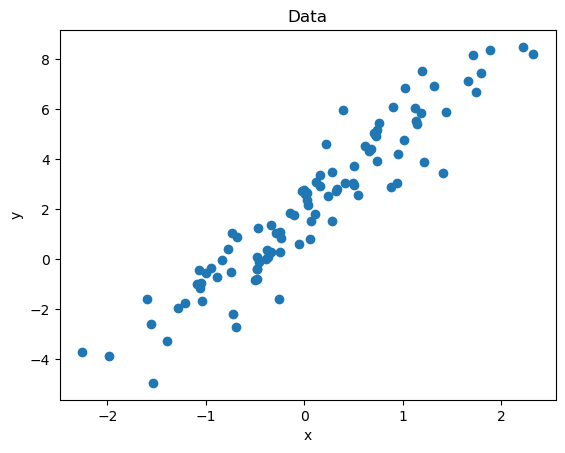

Slope: 3.0750823
Intercept: 1.9433243


In [1]:
import tensorflow as tf

# Define the linear regression model using a single dense layer
def make_model():
    model = tf.keras.Sequential([
        tf.keras.layers.Dense(1, input_shape=(1,), name='linear_layer')
    ])
    return model

model_org = make_model()
model_org.save('model_org.keras')
# Generate random input and target data
x = tf.random.normal((100, 1))
y = 3 * x + 2 + tf.random.normal((100, 1), stddev=1.)  # y = 3x + 2 with some noise

# Plot the data
import matplotlib.pyplot as plt
plt.scatter(x, y)
plt.xlabel('x')
plt.ylabel('y')
plt.title('Data')
plt.show()

# Do a linear regression using scikit-learn to get the slope and intercept
from sklearn.linear_model import LinearRegression
model_sk = LinearRegression()
model_sk.fit(x, y)
slope = model_sk.coef_[0][0]
intercept = model_sk.intercept_[0]
print('Slope:', slope)
print('Intercept:', intercept)

### Traing the model using the keras training loop

In [2]:
model = tf.keras.models.load_model('model_org.keras') # Load the model with
optimizer = tf.keras.optimizers.Adam()
#print(optimizer.get_config())
model.compile(optimizer='adam', loss='mse')
history_keras = model.fit(x, y, epochs=100, verbose=0, batch_size=len(x))  # Train the model full batch slower

In [3]:
model = tf.keras.models.load_model('model_org.keras') # Load the model with
optimizer = tf.keras.optimizers.Adam()
#print(optimizer.get_config())
model.compile(optimizer='adam', loss='mse')
history_keras_bs10 = model.fit(x, y, epochs=100, verbose=0, batch_size=10)  # Train the model full batch slower

### Training the model using custom training loop

In [4]:
# Load and compile the model
model = tf.keras.models.load_model('model_org.keras')
optimizer = tf.keras.optimizers.Adam()
loss_fn = tf.keras.losses.MeanSquaredError()

# Print optimizer configuration
print(optimizer.get_config())

# Custom training loop parameters
epochs = 100

# Lists to store loss values for plotting
loss_history = []

# Custom training loop
for epoch in range(epochs):
    with tf.GradientTape() as tape:
        predictions = model(x, training=True)
        loss = loss_fn(y, predictions)

    gradients = tape.gradient(loss, model.trainable_weights)
    optimizer.apply_gradients(zip(gradients, model.trainable_weights))

    loss_value = loss.numpy()
    loss_history.append(loss_value)
    if (epoch + 1) % 10 == 0:
        print(f"Epoch {epoch+1}/{epochs}, Loss: {loss_value:.4f}")

{'name': 'adam', 'learning_rate': 0.0010000000474974513, 'weight_decay': None, 'clipnorm': None, 'global_clipnorm': None, 'clipvalue': None, 'use_ema': False, 'ema_momentum': 0.99, 'ema_overwrite_frequency': None, 'loss_scale_factor': None, 'gradient_accumulation_steps': None, 'beta_1': 0.9, 'beta_2': 0.999, 'epsilon': 1e-07, 'amsgrad': False}
Epoch 10/100, Loss: 16.1093
Epoch 20/100, Loss: 16.0020
Epoch 30/100, Loss: 15.8952
Epoch 40/100, Loss: 15.7890
Epoch 50/100, Loss: 15.6833
Epoch 60/100, Loss: 15.5782
Epoch 70/100, Loss: 15.4738
Epoch 80/100, Loss: 15.3699
Epoch 90/100, Loss: 15.2667
Epoch 100/100, Loss: 15.1640


### Train the model using second order optimization

The basic idea of second order optimization is to update the weights using the inverse of the Hessian matrix. The update rule is given by:
$$
w_{t+1} = w_t - \alpha H^{-1} \nabla L(w_t)
$$
where $H$ is the Hessian matrix, $\nabla L(w_t)$ is the gradient of the loss function at $w_t$ and $\alpha$ is the learning rate which is set to 1 in the original Newton's method.

In [5]:
# Load and compile the model
model = tf.keras.models.load_model('model_org.keras')
optimizer = tf.keras.optimizers.Adam()

# Define the training loop
epochs = 100
learning_rate = 1.0 # learning rate < 1 --> Damping factor
loss_history_newton = []
for epoch in range(epochs):
    with tf.GradientTape(persistent=True) as tape2:
        with tf.GradientTape(persistent=True) as tape1:
            # Forward pass
            y_pred = model(x, training=True)
            loss = tf.reduce_mean(tf.square(y - y_pred))
        
        # Compute first-order gradients
        grads = tape1.gradient(loss, model.trainable_variables)
    
    # Compute second-order derivatives (Hessian)
    hessians = [tape2.jacobian(g, model.trainable_variables) for g in grads]

    # Update parameters using second-order optimization (Newton-Raphson method)
    for i, var in enumerate(model.trainable_variables):
        grad = grads[i]
        hessian = hessians[i]

        # Ensure all elements of hessian list have the same shape
        hessian = [tf.reshape(h, (-1, h.shape[-1])) for h in hessian]
        
        # Sum the Hessians over the batch dimension if needed
        hessian = tf.reduce_sum(tf.stack(hessian, axis=0), axis=0)

        # Reshape Hessian to 2D if necessary
        hessian_shape = hessian.shape
        if len(hessian_shape) > 2:
            hessian = tf.reshape(hessian, [hessian_shape[0], -1])

        # Check if the Hessian is square and invertible
        if hessian.shape[0] == hessian.shape[1]:
            # Add a small value to the diagonal for numerical stability
            hessian += tf.eye(hessian.shape[0]) * 1e-5
            
            # Compute the inverse of the Hessian
            hessian_inv = tf.linalg.inv(hessian)
            
            # Compute the parameter update
            delta = learning_rate * tf.matmul(hessian_inv, tf.expand_dims(grad, axis=1))
            var.assign_sub(tf.squeeze(delta))
        else:
            # If Hessian is not square, use gradient descent step
            print(f"Hessian is not square at variable {i}, using gradient descent instead")
            var.assign_sub(learning_rate * grad)

    loss_history_newton.append(loss.numpy())
    # Print loss every 10 epochs
    if epoch % 10 == 0 or epoch < 10:
        print(f"Epoch {epoch}, Loss: {loss.numpy()}")

Epoch 0, Loss: 16.206314086914062
Epoch 1, Loss: 1.0359398126602173
Epoch 2, Loss: 1.014768362045288
Epoch 3, Loss: 1.0142793655395508
Epoch 4, Loss: 1.0142680406570435
Epoch 5, Loss: 1.0142676830291748
Epoch 6, Loss: 1.0142676830291748
Epoch 7, Loss: 1.0142676830291748
Epoch 8, Loss: 1.0142676830291748
Epoch 9, Loss: 1.0142676830291748
Epoch 10, Loss: 1.0142676830291748
Epoch 20, Loss: 1.0142676830291748
Epoch 30, Loss: 1.0142676830291748
Epoch 40, Loss: 1.0142676830291748
Epoch 50, Loss: 1.0142676830291748
Epoch 60, Loss: 1.0142676830291748
Epoch 70, Loss: 1.0142676830291748
Epoch 80, Loss: 1.0142676830291748
Epoch 90, Loss: 1.0142676830291748


In [6]:
# Print final model parameters
a, b = model.layers[0].get_weights()
print(f"Trained parameters: a = {a[0][0]}, b = {b[0]}")
# Compare with the true parameters
print(f"True parameters (SK_Learn): a = {slope}, b = {intercept}")

Trained parameters: a = 3.075082540512085, b = 1.943324089050293
True parameters (SK_Learn): a = 3.075082302093506, b = 1.943324327468872


(0.0, 10.0)

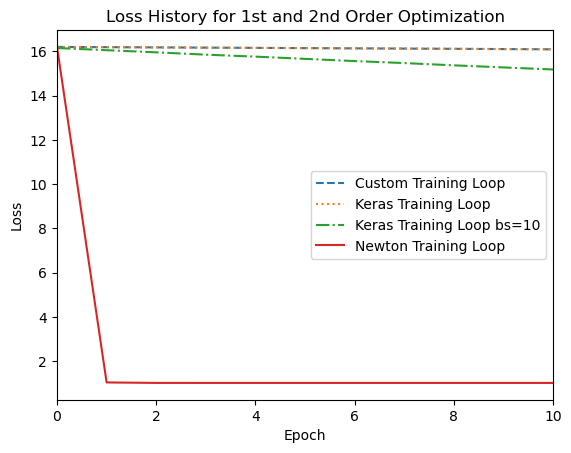

In [7]:
### Compare the loss history of the custom training loop with the Keras training loop
plt.plot(loss_history, label='Custom Training Loop', linestyle='dashed')
plt.plot(history_keras.history['loss'], label='Keras Training Loop', linestyle='dotted')
plt.plot(history_keras_bs10.history['loss'], label='Keras Training Loop bs=10', linestyle='dashdot')
plt.plot(loss_history_newton, label='Newton Training Loop')
plt.legend()
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Loss History for 1st and 2nd Order Optimization')
plt.xlim([0, 10])